In [19]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import tensorflow as tf
from tensorflow import keras


# Global Configuration variables

In [299]:
# Debug and test variables
# Do not process all the audio in the dataset (for faster execution during script development)
REDUCED_MODE = 1
# Number of dataset audios per folder to process in the reduced-mode.
REDUCED_MODE_AUDIONUM = 25

# Audio processing variables
AUDIO_SR = 44100  # Audio sampling in Hertz
AUDIO_N_FFT = 2048  # Samples per FFT window
AUDIO_HOP_LEN = 512
AUDIO_N_MELS = 60

AUDIOSEG_SIZE = 41  # windows per subAudio / segment
AUDIOSEG_OVERLAP = 0.5  # normalized

AUDIOSEG_OVERSAMPLING = 3  # how many times to increase the engine category samples
AUDIOSEG_CLASS2OVERSAMPLE = 5  # Oversample the engine class (5)

# Preprocessing
PREPROC_SKIP = 0  # Skip preprocessing files and use previosuly saved '.npz'

# Paths and folders
audiosPath = 'UrbanSounds8K/1_audioFiles/'
audiosSubPaths = np.array(['fold1', 'fold2', 'fold3', 'fold4',
                          'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10'])
processedPath = "UrbanSounds8K/2_featuresProcessed/"
confusionPath = "UrbanSounds8K/3_confusionMatrix/"
confusionFile = "confusion_matrix"
logPath = "UrbanSounds8k/4_processingLog"


# Methods for preprocessing and feature extraction

In [3]:
# Divide an audio file into shorter and overlapped parts.
def audioSegmentation(audioData, subAudioSize, overlapFactor=AUDIOSEG_OVERLAP):
    start = 0
    while start < len(audioData):
        yield int(start), int(start + subAudioSize)
        start += (subAudioSize // (1/(1-overlapFactor)))



# Add white noise to signal respecting a maximum amplitude based on RMS energy of the original signal
def audioAddGaussianNoise(audioData, sampleRate = AUDIO_SR, maxAmplitude_percRMS = 0.1):
    signalRMS = (np.average(audioData**2))**(1/2);
    
    randomFact1 = np.random.rand(1);
    randomFact2 = np.random.rand(1);

    factMax =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 > randomFact2 else randomFact2);
    factMin =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 < randomFact2 else randomFact2);

    transform = AddGaussianNoise(min_amplitude=factMin, max_amplitude=factMax,p=1);
    augSoundSignal = transform(audioData,sample_rate=44100);

    return augSoundSignal


In [5]:
### Define helper functions ###
def extractSoundFeature(audiosPath, audiosSubPath, n_mels=AUDIO_N_MELS, n_windows=AUDIOSEG_SIZE, hopLength=AUDIO_HOP_LEN, audioOverFact=AUDIOSEG_OVERSAMPLING, audioOverClass=AUDIOSEG_CLASS2OVERSAMPLE):

    subAudioSize = hopLength * (n_windows - 1)
    features_AM, origClasses_A = [], []

    # Map all audio samples paths inside the folder
    allAudiosPath_A = glob.glob(os.path.join(
        audiosPath, audiosSubPath, "*.wav"))

    # Iterate and extract features from each audio
    idxAudio = 0
    idxSegment = 0
    for audioPath in allAudiosPath_A:
        idxAudio = idxAudio+1
        # Early stop for reduced mode
        if REDUCED_MODE == 1 and idxAudio == REDUCED_MODE_AUDIONUM:
            break

        # Extract '.wav' audio to an 1-D array + audio classification
        audioData_A, sr = librosa.load(audioPath, sr=AUDIO_SR)
        audioClass = int(audioPath.split('/')[2].split('-')[1])

        # Loop more than once in the same audio (oversampling)
        if audioClass == audioOverClass:
            maxRepeatOverSampl = audioOverFact
        else:
            maxRepeatOverSampl = 1

        idxOverSampl = 0
        for idxOverSampl in np.arange(maxRepeatOverSampl):

            # Create subsegments from audio file and extract the features
            subAudioLogSpect_AM, subAudioClass = [], []  # Init arrays
            for (start, end) in audioSegmentation(audioData_A, subAudioSize):
                if (len(audioData_A[start:end]) == subAudioSize):
                    idxSegment = idxSegment+1
                    # Append audio class to segments class array
                    subAudioClass.append(audioClass)

                    # Extract audio data - 1D Array
                    segAudioData_A = audioData_A[start:end]

                    # Transform to spectogram in decibels - 2D Matrix
                    segAudioSpect_M = librosa.feature.melspectrogram(
                        y=segAudioData_A, n_mels=n_mels)
                    segAudioSpectDecibels_M = librosa.amplitude_to_db(
                        segAudioSpect_M)

                    # Reshape and append to preprocessed spectograms
                    segAudioSpectDecibels_M = segAudioSpectDecibels_M.T.flatten()[
                        :, np.newaxis].T
                    subAudioLogSpect_AM.append(segAudioSpectDecibels_M)

            subAudioLogSpect_AM = np.asarray(subAudioLogSpect_AM).reshape(
                len(subAudioLogSpect_AM), n_mels, n_windows, 1)

            # If last audio not empty, stack together with others
            if len(subAudioLogSpect_AM) > 0:
                features_AM.append(subAudioLogSpect_AM)
                origClasses_A.append(subAudioClass)

    print('Num of segments for this folder - ',
          idxSegment, ' - out of - ', idxAudio, ' audios.')

    # Stack all data 'per segment' and not 'per audio'
    features_AM = np.concatenate(features_AM, axis=0)
    origClasses_A = np.concatenate(origClasses_A, axis=0)

    # Convert UrbanSounds8K class to binary 'is/isn't engine'
    engineClasses_A = np.array(
        list(map(lambda x: 1 if x == 5 else 0, origClasses_A)))  # @TODO Still not used

    return features_AM, engineClasses_A


# CNN Model Definition - with ReLu activation

In [6]:
### Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu=0):
    keras.backend.clear_session()

    pool_size = (2, 2)
    kernel_size = (3, 3)
    input_shape = (60, 41, 1)
    num_classes = 2  # 10

    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same",
              input_shape=input_shape, dilation_rate=1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    # model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size,
              padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    #model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model


# Audio Processing and Features Extraction

Num of segments for this folder -  356  - out of -  25  audios.
Num of segments for this folder -  434  - out of -  25  audios.
Num of segments for this folder -  354  - out of -  25  audios.
Num of segments for this folder -  344  - out of -  25  audios.
Num of segments for this folder -  368  - out of -  25  audios.
Num of segments for this folder -  470  - out of -  25  audios.
Num of segments for this folder -  384  - out of -  25  audios.
Num of segments for this folder -  708  - out of -  25  audios.
Num of segments for this folder -  384  - out of -  25  audios.
Num of segments for this folder -  449  - out of -  25  audios.


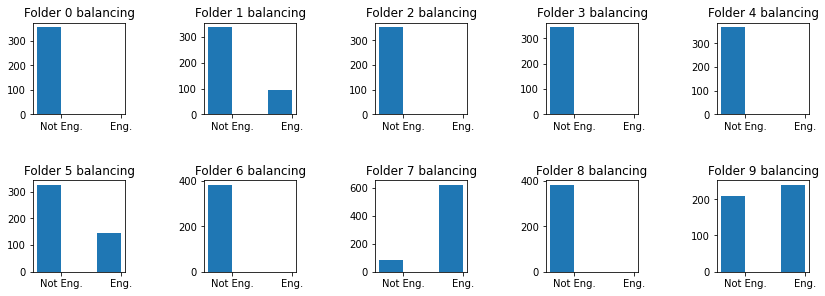

In [308]:
# Pre-process and extract feature from the data
if PREPROC_SKIP == 0:
    fig, axes = plt.subplots(2, 5)
    axes = axes.ravel()
    fig.set_figheight(10*0.5)
    fig.set_figwidth(25*0.5)
    fig.tight_layout(pad=4.5)

    # Loop through all audio folders
    idxFold = 0
    for audioSubPath in audiosSubPaths:
        # Extract files from folder and save externally for reuse
        features_AM, classes_A = extractSoundFeature(audiosPath, audioSubPath)
        np.savez("{0}{1}".format(processedPath, audioSubPath),
                 features=features_AM, classes=classes_A)

        # Plot histogram of data balancing per folder
        axes[idxFold].set_title('Folder ' + str(idxFold+1) + ' balancing')
        tmpData = np.asarray(classes_A)
        tmpData = [np.count_nonzero(tmpData == 0),
                   np.count_nonzero(tmpData == 1)]
        axes[idxFold].bar(['Not Eng.', 'Eng.'], tmpData,
                          align='edge', width=-0.4, label="Train")

        idxFold += 1


In [8]:
# Do stratified sampling and data augmentation to balance the train dataset toward a 50/50 distribution.
# Oversample the engine sounds
# Undersample the general sounds
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

# preprocessing.label_binarize -> for 1 vs all classification


# CNN Training and Testing

In [35]:
### Train and evaluate via 10-audiosSubPaths cross-validation ###
kf = KFold(n_splits=10)

# List containing all confusion matrix for all K-Fold Train-Test
allConfusionMatrix_AM = []
# Array containing the results of the training for each train/test set.
allFitResults_A = []

# Loop to traint-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(audiosSubPaths):
    idx = idx+1

    print('--> Starting a loop! - Folder ', idx)

    x_train, y_train = [], []

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        print('-> Getting data from TRAINING folder ', idxTrainFolder+1)
        # Read pre-saved features or segments of an audio file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(processedPath,
                             audiosSubPaths[idxTrainFolder]), allow_pickle=True)

        # Append all the 'features' and 'classes' train datasets
        # in a single list containing all train folders data
        x_train.append(train_data["features"])
        y_train.append(train_data["classes"])

    # Stack all the folders in a single X/Y dataset
    x_train = np.concatenate(x_train, axis=0).astype(np.float32)
    y_train = np.concatenate(y_train, axis=0).astype(np.float32)
    print('-> TRAIN dataset size: ', len(x_train))

    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders
    # Load test data from the test folder
    print('\n-> Getting data from TESTING folder ', test_index+1)
    test_data = np.load("{0}/{1}.npz".format(processedPath,
                        audiosSubPaths[test_index][0]), allow_pickle=True)
    x_test = test_data["features"]
    y_test = test_data["classes"]
    print('-> TEST dataset size: ', len(x_test))

    CNN_model = CNN_modelDefinition(useLeakyRelu=1)

    print('\n--> Fitting model!')
    allFitResults_A.append(CNN_model.fit(x_train, y_train, validation_data=(
        x_test, y_test), epochs=1, batch_size=96, verbose=1))

    # Predict results from test data
    y_test_pred = []
    y_test_pred = CNN_model.predict(x_test)  # Categorical results
    y_test_pred = np.asarray(tf.argmax(y_test_pred, axis=1))  # OHE to Category

    # Append the confusion matrix of this K-Fold run to a matirx list
    allConfusionMatrix_AM.append(confusion_matrix(
        y_test, y_test_pred, normalize='true'))

    # Early stop for reduced mode
    if REDUCED_MODE == 1:
        break

# Save the resulting confusion matrices
np.savez("{0}{1}".format(confusionPath, confusionFile),
         allConfusionMatrix=allConfusionMatrix_AM)


--> Starting a loop! - Folder  1
-> Getting data from TRAINING folder  2
-> Getting data from TRAINING folder  3
-> Getting data from TRAINING folder  4
-> Getting data from TRAINING folder  5
-> Getting data from TRAINING folder  6
-> Getting data from TRAINING folder  7
-> Getting data from TRAINING folder  8
-> Getting data from TRAINING folder  9
-> Getting data from TRAINING folder  10
-> TRAIN dataset size:  44527

-> Getting data from TESTING folder  [1]
-> TEST dataset size:  5504

--> Fitting model!
464/464 [==============================] - 153s 329ms/step - loss: 0.2162 - accuracy: 0.9216 - val_loss: 0.1796 - val_accuracy: 0.9393


Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

# Plot all the confusion matrix

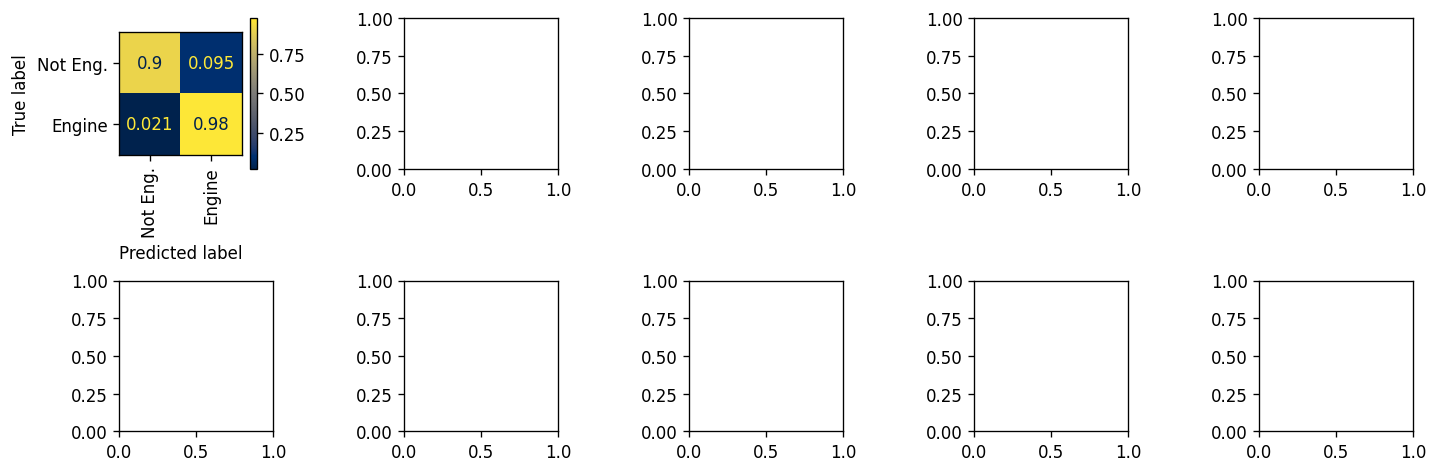

In [164]:
# Plot all confusion matrix
from matplotlib.pyplot import text
from numpy import size


f, a = plt.subplots(2, 5, dpi=120)
f.set_figheight(10*.5)
f.set_figwidth(25*.5)
f.tight_layout(pad=4.5)


idxRow = 0
idxCol = 0
for cm in allConfusionMatrix_AM:
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=['Not Eng.', 'Engine'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cmDisplay)

    cmPlt = cmDisplay.plot(ax=a[idxRow][idxCol],
                           cmap='cividis', xticks_rotation='vertical')

    idxCol += 1
    if idxCol == 5:
        idxCol = 0
        idxRow = 1


# Plot categories distribution

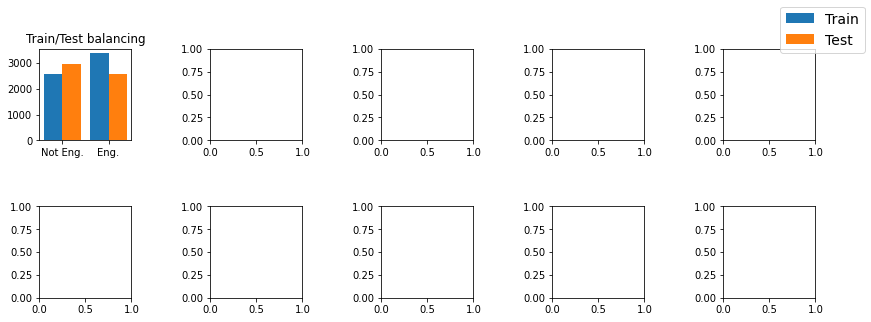

In [296]:
f, a = plt.subplots(2, 5)
a = a.ravel()

f.set_figheight(10*0.5)
f.set_figwidth(25*0.5)
f.tight_layout(pad=4.5)

a[0].set_title('Train/Test balancing')

# Histogram of data per class in train dataset
tmpData = np.asarray(train_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData,
         align='edge', width=-0.4, label="Train")

# Histogram of data per class in test dataset
tmpData = np.asarray(test_data["classes"])
tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
a[0].bar(['Not Eng.', 'Eng.'], tmpData, align='edge', width=0.4, label="Test")

f.legend(fontsize=14)
